In [3]:
import re
import numpy as np
import pandas as pd
import missingno as msno
import pickle

In [4]:
entries = open('/Users/shristi/Documents/InsightDataProject/Data/ProcessedData/drug_interactions.csv').readlines()
print("%d entries" % len(entries))

253281 entries


In [5]:
dataset = []
ignored = 0
for entry in entries[1:]:
    elems = entry.split(',')
    elems = [re.sub(r'[^a-zA-Z0-9_ ]+', '', elem) for elem in elems]
    elems = [elem.strip().lower() for elem in elems]
    # check proper number of elements and that both entities are present in description
    if len(elems) != 3 or not (elems[0] in elems[2] and elems[1] in elems[2]):
        ignored += 1
    else:
        dataset.append(elems)
print('ignored %d entries' % ignored)

ignored 2225 entries


In [6]:
dataset[:10]

[['abacavir',
  'lepirudin',
  'the serum concentration of abacavir can be decreased when it is combined with lepirudin'],
 ['abciximab',
  'lepirudin',
  'abciximab may increase the anticoagulant activities of lepirudin'],
 ['aceclofenac',
  'lepirudin',
  'aceclofenac may increase the anticoagulant activities of lepirudin'],
 ['acenocoumarol',
  'lepirudin',
  'lepirudin may increase the anticoagulant activities of acenocoumarol'],
 ['acetylsalicylic acid',
  'lepirudin',
  'acetylsalicylic acid may increase the anticoagulant activities of lepirudin'],
 ['adapalene',
  'lepirudin',
  'adapalene may increase the anticoagulant activities of lepirudin'],
 ['alfuzosin',
  'lepirudin',
  'the serum concentration of alfuzosin can be increased when it is combined with lepirudin'],
 ['allylestrenol',
  'lepirudin',
  'the therapeutic efficacy of lepirudin can be decreased when used in combination with allylestrenol'],
 ['alprazolam',
  'lepirudin',
  'the serum concentration of alprazolam ca

In [7]:
class Relation:
    def __init__(self):
        self.subject = None
        self.object = None
        self.relation = None
        self.normalizedRelation = None

    def __repr__(self):
        return "%s (%s) %s" % (self.subject, self.normalizedRelation, self.object)

In [8]:
# relationship between entities
def parseEntry(entry):
    e1 = entry[0]
    e2 = entry[1]
    description = entry[2]
    idx1 = description.find(e1)
    idx2 = description.find(e2)
    
    prefix = ""
    if min(idx1, idx2) != 0:
        prefix = description[:min(idx1, idx2)]
    
    if idx1 < idx2:
        relation = (prefix, e1, description[idx1 + len(e1): idx2].strip(), e2)
    else:
        relation = (prefix, e2, description[idx2 + len(e2): idx1].strip(), e1)
    return relation

In [9]:
def getRelation(entry):
    assert(len(entry) == 4)
    relation = Relation()
    if entry[0] == '':
        relation.subject = entry[1]
        relation.relation = entry[2]
        relation.object = entry[3]
    else:
        relation.subject = entry[3]
        relation.relation = entry[0] + "__ " + entry[2]
        relation.object = entry[1]
    return relation

In [10]:
relations = []
for entry in dataset:
    entry = parseEntry(entry)
    relation = getRelation(entry)
    relations.append(relation)

In [44]:
normalized_keywords = [
    "decrease anticoagulant activities",
    "increase anticoagulant activities",
    "serum concentration decreased",
    "serum concentration increased",
    "therapeutic efficacy decreased",
    "metabolism increased",
    "metabolism decreased",
    "adverse effects increased",
    "decrease cardiotoxic activities",
    "increase cardiotoxic activities",
    "increase qtcprolonging activities",
    "decrease excretion rate",
    "decrease antihypertensive activities",
    "increase neuroexcitatory activities",
    "decrease diuretic activities",
    "increase neutropenic activities",
    "increase immunosuppressive activities",
    "increase nephrotoxic activities",
    "decrease absorption",
    "increase hyperkalemic activities",
    "increase hypotensive activities",
    "increase serotonergic activities",
    "increase sedative activities",
    "increase hypoglycemic activities",
    "increase bradycardic activities",
    "increase central nervous system depressant activities",
    "increase antiplatelet activities",
    "decrease antineoplastic activities",
    "risk hypersensitivity reaction increased",
    "increase myopathic rhabdomyolysis activities",
    "increase hyponatremic activities",
    "increase anticholinergic activities",
    "increase neuromuscular blocking activities",
    "increase thrombogenic activities",
    "increase stimulatory activities",
    "increase hepatotoxic activities",
    "increase photosensitizing activities",
    "increase atrioventricular blocking activities",
    "increase adverse neuromuscular activities",
    "increase vasoconstricting activities",
    "serum concentration metabolites reduced",
    "increase antihypertensive activities",
    "increase absorption",
    "increase neurotoxic activities",
    "increase hypokalemic activities",
    "increase hypocalcemic activities",
    "increase hypertensive activities", 
    "increase constipating activities",
    "decrease the stimulatory activities",
    "bioavailability decreased", 
    "decrease sedative activities", 
    "increase respiratory depressant", 
    "decrease bronchodilatory activities", 
    "increase analgesic activities",
    "increase arrhythmogenic activities",
    "increase fluid retaining activities", 
    "increase tachycardic activities", 
    "decrease analgesic activities", 
    "decrease effectiveness",
    "decrease neuromuscular blocking activities", 
    "decrease effectiveness", 
    "increase vasopressor activities", 
    "increase vasodilatory activities",
    "decrease vasoconstricting activities",
    "increase ulcerogenic activities", 
    "increase hyperglycemic activities", 
    "may increase the excretion rate"
    
]

def inorder(relation, keywords):
    if len(keywords) == 0: return True
    idx = [relation.find(k) for k in keywords]
    if idx[0] == -1: return False
    for i in range(1, len(idx)):
        if idx[i] == -1 or idx[i] < idx[i-1]:
            return False
    return True

def normalizeRelation(relation):
    for n in normalized_keywords:
        if inorder(relation.relation, n.split()):
            return n
    return None

In [45]:
num_knowns = 0
num_unknowns = 0
for r in relations:
    normalized = normalizeRelation(r)
    r.normalizedRelation = normalized
    if normalized == None:
        #print("unknown: %s" % r.relation)
        num_unknowns += 1
    else:
        num_knowns += 1
print("known: %d, unknown:%d" % (num_knowns, num_unknowns))

known: 250906, unknown:149


In [48]:
len(normalized_keywords)

67

In [59]:
#analyze the distribution of the labels 
relation_types = {}
for relation in relations:
    relation_type = relation.normalizedRelation
    if relation_type in relation_types.keys(): 
        value = relation_types[relation_type]
        relation_types[relation_type] = value + 1
    else: 
        relation_types[relation_type] = 1

In [60]:
relation_types_df = pd.DataFrame(relation_types.items(), columns = ['Relations', 'Frequency'])

In [56]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
relation_types_df.head()
relation_types_df.sort_values(by = ['Frequency'], ascending = False, inplace = True)
#relation_types_df= relation_types_df[relation_types_df.Frequency >500]

In [62]:
relation_types_df

,Relations,Frequency
6,adverse effects increased,72825
2,serum concentration increased,44654
7,metabolism decreased,30983
0,serum concentration decreased,17295
24,increase hypotensive activities,12193
3,therapeutic efficacy decreased,10382
1,increase anticoagulant activities,8807
19,increase qtcprolonging activities,7266
41,increase central nervous system depressant act...,5918
5,metabolism increased,5379


[Text(0, 0, 'the risk or severity of adverse effects can be increased when __ is combined with'),
 Text(0, 0, 'the serum concentration of __ can be increased when it is combined with'),
 Text(0, 0, 'the metabolism of __ can be decreased when combined with'),
 Text(0, 0, 'the serum concentration of __ can be decreased when it is combined with'),
 Text(0, 0, 'may increase the hypotensive activities of'),
 Text(0, 0, 'the therapeutic efficacy of __ can be decreased when used in combination with'),
 Text(0, 0, 'may increase the anticoagulant activities of'),
 Text(0, 0, 'may increase the qtcprolonging activities of'),
 Text(0, 0, 'may increase the central nervous system depressant cns depressant activities of'),
 Text(0, 0, 'the metabolism of __ can be increased when combined with'),
 Text(0, 0, 'may increase the hypoglycemic activities of'),
 Text(0, 0, 'may decrease the antihypertensive activities of'),
 Text(0, 0, 'may decrease the excretion rate of'),
 Text(0, 0, 'may increase the neur

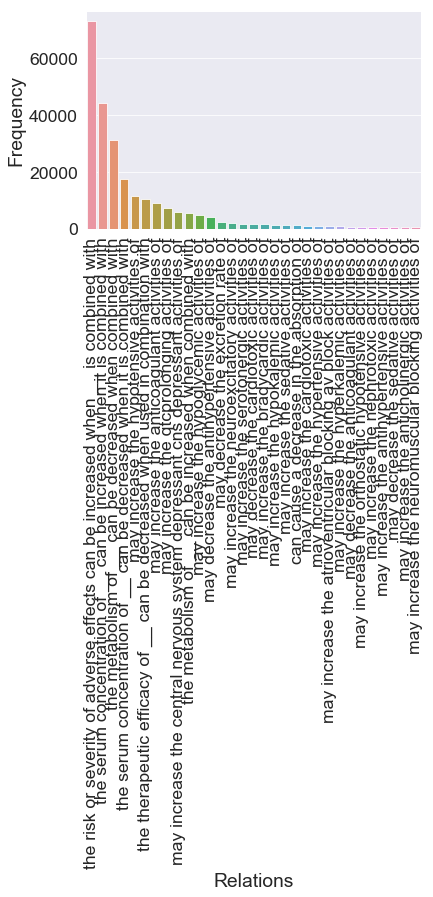

In [19]:
plt.figure()
sns.set(rc={'figure.figsize':(14.5,11.27)})
#sns.set(font= 14)
sns.set_context("paper", font_scale=2.0)                                                  


g = sns.barplot(x = 'Relations', y = 'Frequency', data = relation_types_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)


In [20]:
selected_relations= [] # selected based on how frequent a particular interaction is 
selected_relation_descriptions = list(relation_types_df['Relations'])# taken > 500 frequency from the dataframe above

for relation in relations: 
    if relation.relation in selected_relation_descriptions: 
        selected_relations.append(relation)
    else: 
        continue         
    

In [21]:
selected_relations[1:10]

[abciximab (increase anticoagulant activities) lepirudin,
 aceclofenac (increase anticoagulant activities) lepirudin,
 lepirudin (increase anticoagulant activities) acenocoumarol,
 acetylsalicylic acid (increase anticoagulant activities) lepirudin,
 adapalene (increase anticoagulant activities) lepirudin,
 lepirudin (serum concentration increased) alfuzosin,
 allylestrenol (therapeutic efficacy decreased) lepirudin,
 lepirudin (serum concentration increased) alprazolam,
 alprostadil (increase anticoagulant activities) lepirudin]

In [22]:
def selected_relations_to_labels(selected_relations):
    selected_interactions = {}
    for selected_relation in selected_relations: 
        drug_pair = (selected_relation.subject, selected_relation.object)
        interaction = selected_relation.normalizedRelation
        selected_interactions[drug_pair]= interaction
    return selected_interactions
selected_interactions = selected_relations_to_labels(selected_relations)


In [23]:
fingerprints = pd.read_pickle("/Users/shristi/Documents/InsightDataProject/Data/ProcessedData/Fingerprints.pkl")
fingerprints.head()
#type(fingerprints)

,SMILES,Molecular_Fingerprint
DrugName,,
Lepirudin,COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Cetuximab,COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Dornase alfa,COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Denileukin diftitox,COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Etanercept,COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
fingerprints.index = fingerprints.index.str.lower()
fingerprints_dict = fingerprints.to_dict(orient = 'index')

In [25]:
list(fingerprints_dict.items())[0]

('lepirudin',
 {'SMILES': 'COCCOC[C@H](CC1(CCCC1)C(=O)N[C@H]1CC[C@H](CC1)C(O)=O)C(O)=O',
  'Molecular_Fingerprint': array([0., 0., 0., ..., 0., 0., 0.])})

In [26]:
#check if all the drugs that are in selected interactions are also in fingerprints. if not throw them out of selected
#interactions. Selected interactions will be the starting point of 
def check_drug_presence(fingerprints, selected_interactions):
    keys_to_delete = []
    for key in selected_interactions: 
        keys_to_check = [key[0], key[1]]
        #print(keys_to_check)
        result =  all(elem in fingerprints.keys() for elem in keys_to_check)
        if result:
            continue 
        else: 
            keys_to_delete.append(key) 
    return keys_to_delete
    
keys_to_delete = check_drug_presence(fingerprints_dict, selected_interactions)

In [27]:
len(selected_interactions)

243263

In [28]:
len(keys_to_delete)

29261

In [29]:
len(fingerprints_dict)

7452

In [30]:
len(keys_to_delete)
for key_to_delete in keys_to_delete:
    del selected_interactions[key_to_delete]
    

In [31]:
list(selected_interactions.items())[0]



(('lepirudin', 'abacavir'), 'serum concentration decreased')

In [32]:
def get_label_map(selected_interactions):
    elems = sorted(set(selected_interactions.values()))
    return {elems[i]:i for i in range(len(elems))}

def get_reverse_label_map(selected_interactions):
    elems = sorted(set(selected_interactions.values()))
    return {i:elems[i] for i in range(len(elems))}

def featurize_pairs(fingerprints, selected_interactions, label_map):
    X = []
    Y = []
    for key in selected_interactions:
        drug_subject = key[0]
        drug_object = key[1]
        
        feature_subject = fingerprints[drug_subject]['Molecular_Fingerprint']
        feature_object = fingerprints[drug_object]['Molecular_Fingerprint']
        print(feature_object.shape)
        features = feature_subject + feature_object
        print(features.shape)
        label = label_map[selected_interactions[key]]
        break 
        X.append(features)
        Y.append(label)
    return X,Y

label_map = get_label_map(selected_interactions)
print(label_map)
X,Y = featurize_pairs(fingerprints_dict, selected_interactions, label_map)


{'adverse effects increased': 0, 'decrease absorption': 1, 'decrease anticoagulant activities': 2, 'decrease antihypertensive activities': 3, 'decrease cardiotoxic activities': 4, 'decrease excretion rate': 5, 'decrease sedative activities': 6, 'increase anticholinergic activities': 7, 'increase anticoagulant activities': 8, 'increase antihypertensive activities': 9, 'increase atrioventricular blocking activities': 10, 'increase bradycardic activities': 11, 'increase cardiotoxic activities': 12, 'increase central nervous system depressant activities': 13, 'increase hyperkalemic activities': 14, 'increase hypertensive activities': 15, 'increase hypoglycemic activities': 16, 'increase hypokalemic activities': 17, 'increase hypotensive activities': 18, 'increase nephrotoxic activities': 19, 'increase neuroexcitatory activities': 20, 'increase neuromuscular blocking activities': 21, 'increase qtcprolonging activities': 22, 'increase sedative activities': 23, 'increase serotonergic activiti

In [ ]:
sns.set()
plt.hist(a)
plt.title("Number of non zero values in the ECFP features of drug pairs", fontsize = 18)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Number of non-zero elements", fontsize= 16)


In [ ]:
print(X[0])
print(Y[0])
print("num x:%d, num y:%d" % (len(X), len(Y)))

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, train_size=0.7)

In [ ]:
X_train[0].shape


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=1123)
rf.fit(X_train, y_train)


In [ ]:
rf.score(X_test, y_test)


In [ ]:
from joblib import dump, load
#dump(rf, '/Users/shristi/Documents/InsightDataProject/Models/RFmodel.joblib') 


In [ ]:
np.array(y_test)


In [ ]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
confusion_matrix(y_test, rf.predict(X_test))


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    #fig.tight_layout()
    return ax

In [ ]:
y_pred = rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
y_test[:10]

In [ ]:
class_names = np.array([str(i) for i in range(30)])
plot_confusion_matrix(y_test, y_pred, class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
fingerprints.head(20)

In [ ]:
importance = list(rf.feature_importances_)
importance2 = []
for imp in importance: 
    if imp  >= 0.5:
        print(imp)

        importance2.append(i)

In [ ]:
importance2

In [ ]:
plt.figure(figsize = (12, 8))
plt.bar(list(range(0,len(importance2))),importance2)

In [ ]:
from joblib import dump, load
#rf = load('/Users/shristi/Documents/InsightDataProject/clf.joblib')

def predict(sub, obj):
    if sub not in fingerprints_dict.keys():
        print("fingerprints not available for %s" % sub)
        return
    if obj not in fingerprints_dict.keys():
        print("fingerprints not available for %s" % obj)
        return
    f1 = fingerprints_dict[sub]['Molecular_Fingerprint']
    f2 = fingerprints_dict[obj]['Molecular_Fingerprint']
    pair_fingerprint = f1+f2
    result = rf.predict([pair_fingerprint])
    return result
    #print(pair_fingerprint)

prediction = predict("levonorgestrel", "lamotrigine")

In [ ]:
labels = get_reverse_label_map(selected_interactions)
labels[prediction[0]]